In [1]:
import tszpower as tsz
import jax.numpy as jnp
import jax
import psutil
import os
import matplotlib.pyplot as plt
from functools import partial
from typing import Optional, Tuple
import numpy as np
import jax
import jax.numpy as jnp
import pylab as pl
import scipy.integrate as integrate
# DTYPE = jnp.float16

PATH_TO_CLASS_SZ_DATA not set. Setting it now...
Defaulting to: /home/lx256/class_sz_data_directory


2025-06-24 02:07:31.829791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750727251.847278 1360659 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750727251.852603 1360659 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-24 02:07:35.138394: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/lx256/tsz_project/tszpower/tszpower/__init__.py:1: DeprecationWarning: compute_class_szfast is deprecated. Use initialize_classy_szfast instead.
  from .config import classy_sz
/home/lx256/envs/tsz_env/lib64/pyth

In [2]:
def print_memory_usage(note=""):
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / 1024**2  # in MB
    print(f"[{note}] Memory usage: {mem:.2f} MB")

In [3]:
# 1) Define parameters
allparams = {
    'omega_b': 0.049*0.68**2,
    'omega_cdm': (0.31-0.049)*0.68**2,
    'H0': 68.,
    'tau_reio': 0.0544,
    'ln10^{10}A_s': 3.0352,
    'n_s': 0.965,
    'M_min': 1e14*0.68,
    'M_max': 1e16*0.68,
    # 'ell_min': 2,
    # 'ell_max': 8000,
    # 'dlogell': 0.1,
    'z_min': 0.01,
    'z_max': 3.0,
    'P0GNFW': 8.130,
    'c500': 1.156,
    'gammaGNFW': 0.3292,
    'alphaGNFW': 1.0620,
    'betaGNFW': 5.4807,
    'B': 1.4,
    "cosmo_model": 0, # use mnu-lcdm emulators
    'jax': 1
}
tsz.classy_sz.set(allparams)
tsz.initialise()
print_memory_usage("After initialisation")

/tmp/ipykernel_1360659/3306305697.py:26: DeprecationWarning: compute_class_szfast is deprecated. Use initialize_classy_szfast instead.
  tsz.initialise()


[After initialisation] Memory usage: 5267.77 MB


In [4]:
tsz.classy_sz.get_sigma8_and_der(params_values_dict=allparams)
print_memory_usage("After computation")

[After computation] Memory usage: 5274.82 MB


In [5]:
z_min = allparams['z_min']
z_max = allparams['z_max']
z_grid = jnp.geomspace(z_min, z_max, 10000)

M_min = allparams['M_min']
M_max = allparams['M_max']
m_grid = jnp.geomspace(M_min, M_max, 10000)
logm_grid = jnp.log(m_grid)

In [6]:
# 2) Get halo mass function dndlnm over the same z,m
def get_hmf_for_z(zp):
    return tsz.get_hmf_at_z_and_m(z=zp, m=m_grid, params_values_dict=allparams)

In [7]:
dnddzlnm_grid = jax.vmap(get_hmf_for_z)(z_grid)  
print_memory_usage("After HMF")

[After HMF] Memory usage: 5302.05 MB


In [8]:
# -------------------------------------------------------------------
# JAX clone of cosmocnc/sim.py:get_samples_pdf_2d
# -------------------------------------------------------------------
from functools import partial
from typing import Optional, Tuple

import jax
import jax.numpy as jnp
import jax.scipy.ndimage as jnd

# -------------------------------------------------------------------
# 1. deterministic helper (jitted, static shapes)
# -------------------------------------------------------------------
@partial(jax.jit, static_argnames=("n_z", "n_m"))
def _pdf_and_grids(
    params: dict,
    *,
    n_z: int,
    n_m: int,
    dndlnm_grid: Optional[jnp.ndarray] = None,
    sky_frac: float = 1.0,
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, float]:
    """Return z_grid, lnM_grid, joint PDF, and expected cluster count."""
    z_min, z_max = params["z_min"], params["z_max"]
    M_min, M_max = params["M_min"], params["M_max"]

    # log-spaced grids (same as cosmocnc)
    z_grid   = jnp.geomspace(z_min,  z_max,  n_z)
    m_grid   = jnp.geomspace(M_min,  M_max,  n_m)
    lnM_grid = jnp.log(m_grid)

    # HMF on the grid ------------------------------------------------------
    if dndlnm_grid is None:
        def hmf_at_z(zp):
            return tsz.get_hmf_at_z_and_m(z=zp, m=m_grid,
                                          params_values_dict=params)
        dndlnm_grid = jax.vmap(hmf_at_z)(z_grid)           # (n_z, n_m)

    dV = tsz.dVdzdOmega(z_grid, params_values_dict=params)  # (n_z,)

    # full-sky × sky_frac
    dNdzdlnM = dndlnm_grid * dV[:, None] * (4.0 * jnp.pi * sky_frac)

    # ------------------------------------------------- constant bin widths
# correct, variable bin widths
    dz   = jnp.diff(z_grid,   append=z_grid[-1]   * (z_grid[-1]   / z_grid[-2]))
    dlnM = jnp.diff(lnM_grid, append=lnM_grid[-1] + (lnM_grid[-1] - lnM_grid[-2]))

    dN_cell = dNdzdlnM * dz[:, None] * dlnM[None, :]

    N_exp   = dN_cell.sum()
    pdf     = dN_cell / N_exp                             # Σ = 1

    return z_grid, lnM_grid, pdf, N_exp


# -------------------------------------------------------------------
# 2. exact inverse-CDF sampler (no jit – dynamic shapes OK)
# -------------------------------------------------------------------
# @jax.jit
def _sample_from_2d_pdf(
    key: jax.Array,
    n_samples: int,
    x: jnp.ndarray,           # z grid  (length Nx)
    y: jnp.ndarray,           # lnM grid (length Ny)
    pdf: jnp.ndarray,         # (Nx, Ny), Σ = 1
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Reproduces cosmocnc.get_samples_pdf_2d one-for-one."""
    dx = x[1] - x[0]
    dy = y[1] - y[0]

    # --- Conditional CDF P(X|Y) (shape Nx×Ny) ----------------------------
    cdf_xgy = jnp.cumsum(pdf, axis=0) * dx
    cdf_xgy = cdf_xgy / cdf_xgy[-1, :]                    # each column → [0,1]

    # --- Marginal CDF for Y ----------------------------------------------
    pdf_y = pdf.sum(axis=0)                               # integrate over x
    cdf_y = jnp.cumsum(pdf_y) * dx * dy                   # length Ny (not normed)

    # sample Y (ln M) ------------------------------------------------------
    key, k1, k2 = jax.random.split(key, 3)
    u_y = jax.random.uniform(k1, (n_samples,))
    y_samples = jnp.interp(u_y, cdf_y / cdf_y[-1], y)     # identical to NumPy

    # build LUT x(z_unit, y) ----------------------------------------------
    z_unit = jnp.linspace(0.0, 1.0, x.size)               # same “z” axis
    x_matrix = jax.vmap(
        lambda col: jnp.interp(z_unit, col, x)
    )(cdf_xgy.T)                                          # (Ny, Nx)

    # sample X (z) given Y -------------------------------------------------
    u_x = jax.random.uniform(k2, (n_samples,))

    # map_coordinates expects index coordinates
    coords = jnp.vstack([
        u_x * (z_unit.size - 1),                          # z index
        jnp.interp(y_samples, y, jnp.arange(y.size))      # y index
    ])
    x_samples = jnd.map_coordinates(
        x_matrix.T, coords, order=1, mode="nearest"
    )

    return x_samples, y_samples


# -------------------------------------------------------------------
# 3. public catalogue generator (HMF-only)
# -------------------------------------------------------------------
def sample_cluster_catalogue(
    key: jax.Array,
    params_values_dict: dict,
    *,
    n_z: int = 1000,
    n_m: int = 1000,
    dndlnm_grid: Optional[jnp.ndarray] = None,
    sky_frac: float = 1.0,
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    JAX equivalent of catalogue_generator.generate_catalogues_hmf():
    returns arrays  z_cat,  M_cat  (both length N drawn from Poisson).
    """
    z_grid, lnM_grid, pdf, N_exp = _pdf_and_grids(
        params_values_dict,
        n_z=n_z,
        n_m=n_m,
        dndlnm_grid=dndlnm_grid,
        sky_frac=sky_frac,
    )

    key, sub = jax.random.split(key)
    N = int(jax.random.poisson(sub, N_exp))

    key, sub = jax.random.split(key)
    z_cat, lnM_cat = _sample_from_2d_pdf(sub, N, z_grid, lnM_grid, pdf)

    return z_cat, jnp.exp(lnM_cat)         # return M, not ln M


In [9]:
import time
n_cat= 10

# master RNG seed
key = jax.random.key(12310)

# split into 10 sub-keys
subkeys = jax.random.split(key, num=n_cat)

# time the catalogue generation
start_time = time.time()

# draw the catalogues
catalogues = []
for i, k in enumerate(subkeys):
    z_cat, m_cat = sample_cluster_catalogue(
        k,
        params_values_dict=allparams,
        n_z=10000,      # grid resolution in redshift
        n_m=10000,      # grid resolution in mass
        sky_frac=1.0,    # full sky
    )
    m_cat = m_cat/0.68/1e14  #In unit of 1e14
    catalogues.append((z_cat, m_cat))
    print(f"N clusters in catalogue {i}: {len(z_cat)}")
    
    print_memory_usage(f"After catalogue {i}:")

end_time = time.time()
print(f"Time to generate {n_cat} catalogues: {end_time - start_time:.2f} seconds")

N clusters in catalogue 0: 389454
[After catalogue 0:] Memory usage: 9917.15 MB
N clusters in catalogue 1: 390917
[After catalogue 1:] Memory usage: 9975.26 MB
N clusters in catalogue 2: 390046
[After catalogue 2:] Memory usage: 10017.41 MB
N clusters in catalogue 3: 389967
[After catalogue 3:] Memory usage: 10074.25 MB
N clusters in catalogue 4: 390487
[After catalogue 4:] Memory usage: 10091.02 MB
N clusters in catalogue 5: 389705
[After catalogue 5:] Memory usage: 10105.67 MB
N clusters in catalogue 6: 390657
[After catalogue 6:] Memory usage: 10124.30 MB
N clusters in catalogue 7: 390228
[After catalogue 7:] Memory usage: 10159.66 MB
N clusters in catalogue 8: 391851
[After catalogue 8:] Memory usage: 10172.23 MB
N clusters in catalogue 9: 389755
[After catalogue 9:] Memory usage: 10208.42 MB
Time to generate 10 catalogues: 77.07 seconds


In [10]:
for idx, (z_arr, m_arr) in enumerate(catalogues):
    # convert JAX DeviceArrays → NumPy (host) arrays
    z_np = np.asarray(z_arr)
    m_np = np.asarray(m_arr)

    # two-column matrix for np.savetxt
    data = np.column_stack([z_np, m_np])

    # save: header "z,M", 6-digit scientific notation to keep files small
    np.savetxt(
        f"cat_{idx}.csv",      # cat_0.csv, cat_1.csv, …
        data,
        fmt="%.6e",            # e.g. 1.234567e-01
        delimiter=",",
        header="z,M",
        comments=""            # keep header line exactly as given
    )

    print(f"Saved cat_{idx}.csv  with {data.shape[0]} rows")

Saved cat_0.csv  with 389454 rows
Saved cat_1.csv  with 390917 rows
Saved cat_2.csv  with 390046 rows
Saved cat_3.csv  with 389967 rows
Saved cat_4.csv  with 390487 rows
Saved cat_5.csv  with 389705 rows
Saved cat_6.csv  with 390657 rows
Saved cat_7.csv  with 390228 rows
Saved cat_8.csv  with 391851 rows
Saved cat_9.csv  with 389755 rows


In [11]:
z_bins_edges = np.linspace(0,3,20)
ln_M_bins_edges = np.linspace(np.log(1),np.log(100),20)
lnM_bins_edges_true = np.linspace(np.log(1e14*0.68), np.log(1e16*0.68),20)

z_bins_centres = (z_bins_edges[0:-1]+z_bins_edges[1:])*0.5
ln_M_bins_centres = (ln_M_bins_edges[0:-1]+ln_M_bins_edges[1:])*0.5

In [12]:
# dnddzlnm_grid 
comov_vol = tsz.dVdzdOmega(z_grid, params_values_dict=allparams)
comov_vol_expanded = comov_vol[:, None]  
integrand = dnddzlnm_grid  * comov_vol_expanded 
sky_frac=1.0
dndz = tsz.simpson(integrand, x=logm_grid, axis=1)
dndlnm = tsz.simpson(integrand, x=z_grid, axis=0)

n_z =  tsz.simpson(dndz, x=z_grid, axis=0)*4*np.pi*sky_frac
n_ln_M = tsz.simpson(dndlnm, x=logm_grid, axis=0)*4*np.pi*sky_frac
print('Total predicted clusters',np.sum(n_z),np.sum(n_ln_M))

Total predicted clusters 389969.80257387395 389969.80257387384


In [13]:
import numpy as np

# ------------------------------------------------------------
# fine 1-D grids and differential counts you already have
# ------------------------------------------------------------
# z_grid        (Nz,)          fine redshift centres
# logm_grid     (Nm,)          fine ln M centres
# dndz          (Nz,)          differential counts  dN/dz   (already *4π sky_frac*)
# dndlnm        (Nm,)          differential counts  dN/dlnM
#
# coarse histogram edges
# z_bins_edges           = np.linspace(0, 3, 20)
# lnM_bins_edges_true    = np.linspace(np.log(1e14*0.68),
#                                      np.log(1e16*0.68), 20)

# ------------------------------------------------------------
# widths of each fine-grid cell (same length as centres)
# ------------------------------------------------------------
dz     = np.diff(z_grid,    append=z_grid[-1]    + (z_grid[-1]    - z_grid[-2]))
dlnM   = np.diff(logm_grid, append=logm_grid[-1] + (logm_grid[-1] - logm_grid[-2]))

# turn densities into *counts per cell*
dN_dz_cell     = dndz   * dz
dN_dlnM_cell   = dndlnm * dlnM

# ------------------------------------------------------------
# helper – sum counts that fall into each coarse bin
# ------------------------------------------------------------
def bin_sum(grid, counts_per_cell, edges):
    idx_lo = np.searchsorted(grid, edges[:-1], side="left")
    idx_hi = np.searchsorted(grid, edges[1:] , side="left")
    return np.array([counts_per_cell[lo:hi].sum() for lo, hi in zip(idx_lo, idx_hi)])

# expected counts in your histogram bins
n_z_bins   = bin_sum(z_grid,    dN_dz_cell,   z_bins_edges)*4*jnp.pi*sky_frac          # length 19
n_lnM_bins = bin_sum(logm_grid, dN_dlnM_cell, lnM_bins_edges_true)*4*jnp.pi*sky_frac      # length 19

# ------------------------------------------------------------
# totals now match the full-sky integral
# ------------------------------------------------------------
print("Σ n_z_bins   =", n_z_bins.sum(),   "  vs  n_z =", n_z.sum())
print("Σ n_lnM_bins =", n_lnM_bins.sum(), "  vs  n_ln_M =", n_ln_M.sum())


Σ n_z_bins   = 390081.06566819584   vs  n_z = 389969.80257387395
Σ n_lnM_bins = 389762.191477902   vs  n_ln_M = 389969.80257387384


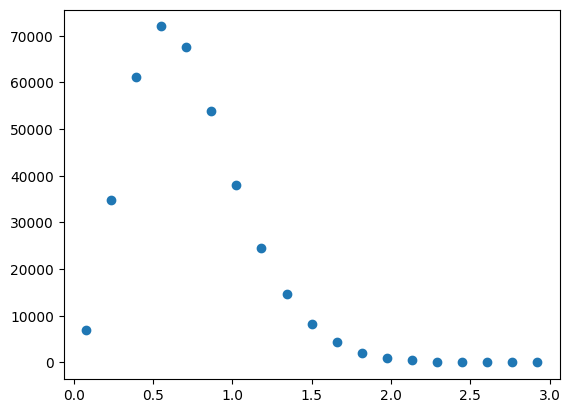

In [14]:
plt.scatter(z_bins_centres, n_z_bins)

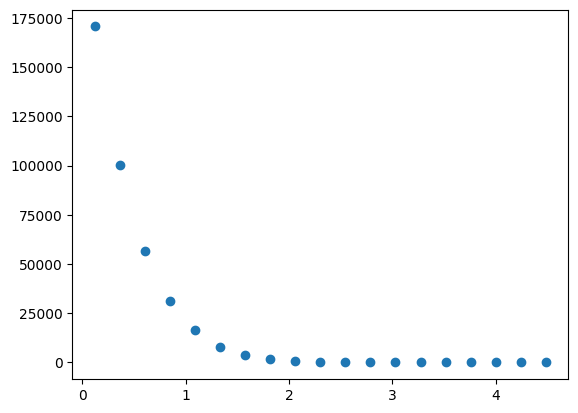

In [15]:
plt.scatter(ln_M_bins_centres, n_lnM_bins)

In [16]:
# catalogue_total = {}
catalogue_total = {           # pre-allocate the four columns you have
    "z"  : np.empty(0, dtype=float),
    "M"  : np.empty(0, dtype=float),
}

for i in range(0,n_cat):

    # catalogue_new = np.loadtxt("/rds/lx256/hpc_work/tsz-project/catalogues_csv/catalogue_so_1e14_" + str(i) + ".csv",allow_pickle=True)[()]
    fname = f"cat_{i}.csv"
    
    # ---- OPTION A: NumPy ---------------------------------------------------
    data = np.genfromtxt(fname, delimiter=",", names=True)      # reads header
    print("N clusters", data.shape[0])

    # append every column into catalogue_total
    for key in catalogue_total:
        catalogue_total[key] = np.concatenate((catalogue_total[key], data[key]))


N clusters 389454
N clusters 390917
N clusters 390046
N clusters 389967
N clusters 390487
N clusters 389705
N clusters 390657
N clusters 390228
N clusters 391851
N clusters 389755


In [17]:
# Histograms (unchanged)
z_hist, _   = np.histogram(catalogue_total["z"],        bins=z_bins_edges)
lnM_hist, _ = np.histogram(np.log(catalogue_total["M"]), bins=ln_M_bins_edges)

z_hist   = z_hist   / n_cat      # average over the 10 mock catalogues
lnM_hist = lnM_hist / n_cat

pl.rc('text', usetex=False)
pl.rc('font', family='serif')

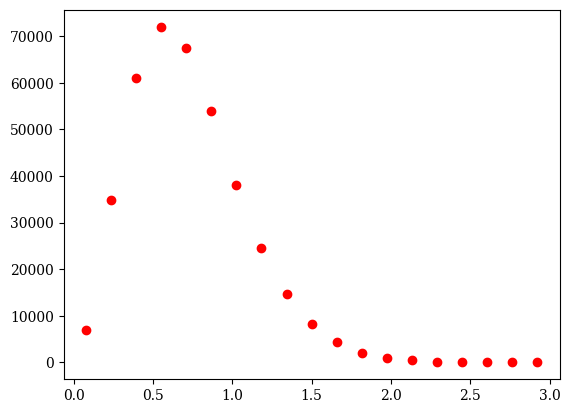

In [18]:
pl.scatter(z_bins_centres,z_hist,s=15,color='blue',zorder=10)
pl.scatter(z_bins_centres, n_z_bins, color = 'red', zorder=10)

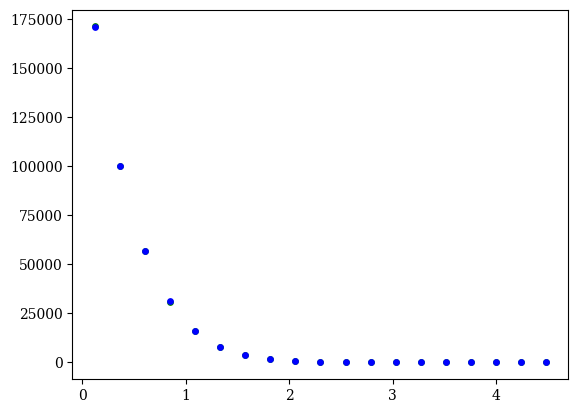

In [19]:
pl.scatter(ln_M_bins_centres,lnM_hist,s=15,color='green',zorder=10)
pl.scatter(ln_M_bins_centres,n_lnM_bins,s=15,color='blue',zorder=10)

<>:7: DeprecationWarning: invalid escape sequence '\D'
<>:7: DeprecationWarning: invalid escape sequence '\D'
/tmp/ipykernel_1360659/2820336489.py:7: DeprecationWarning: invalid escape sequence '\D'
  pl.ylabel("$\Delta N$")


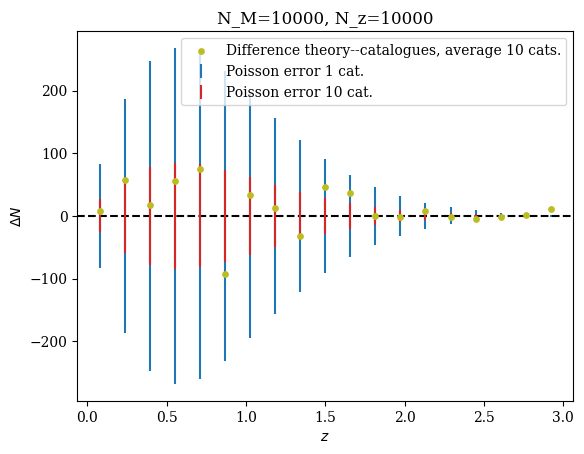

In [25]:
pl.errorbar(z_bins_centres,n_z_bins-n_z_bins,yerr=np.sqrt(n_z_bins),linestyle="none",fmt="",zorder=0,label="Poisson error 1 cat.")
pl.errorbar(z_bins_centres,n_z_bins-n_z_bins,yerr=np.sqrt(n_z_bins)/np.sqrt(n_cat),linestyle="none",fmt="",color="tab:red",zorder=5,label="Poisson error 10 cat.")
pl.scatter(z_bins_centres,z_hist-n_z_bins,s=15,color='tab:olive',zorder=10,label="Difference theory--catalogues, average 10 cats.")

pl.axhline(y=0,linestyle="dashed",color="k")
pl.xlabel("$z$")
pl.ylabel("$\Delta N$")
plt.title("N_M=10000, N_z=10000")
plt.savefig('Delta_n_z.png',dpi=300)
pl.legend()
pl.show()

<>:7: DeprecationWarning: invalid escape sequence '\D'
<>:7: DeprecationWarning: invalid escape sequence '\D'
/tmp/ipykernel_1360659/1962615988.py:7: DeprecationWarning: invalid escape sequence '\D'
  pl.ylabel("$\Delta N$")


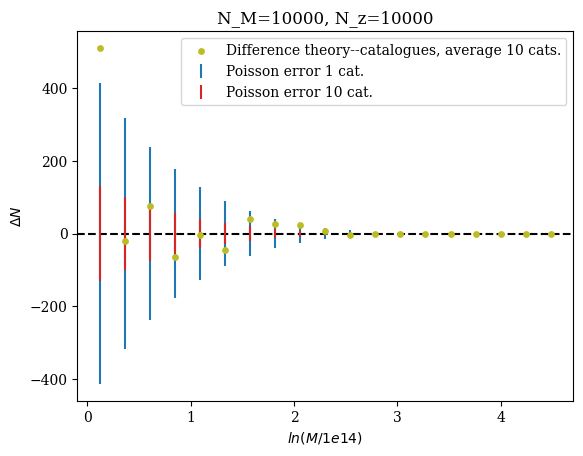

In [24]:
pl.errorbar(ln_M_bins_centres,n_lnM_bins-n_lnM_bins,yerr=np.sqrt(n_lnM_bins),linestyle="none",fmt="",zorder=0,label="Poisson error 1 cat.")
pl.errorbar(ln_M_bins_centres,n_lnM_bins-n_lnM_bins,yerr=np.sqrt(n_lnM_bins)/np.sqrt(n_cat),linestyle="none",fmt="",color="tab:red",zorder=5,label="Poisson error 10 cat.")
pl.scatter(ln_M_bins_centres,lnM_hist-n_lnM_bins,s=15,color='tab:olive',zorder=10,label="Difference theory--catalogues, average 10 cats.")

pl.axhline(y=0,linestyle="dashed",color="k")
pl.xlabel("$ln(M/1e14)$")
pl.ylabel("$\Delta N$")
plt.title("N_M=10000, N_z=10000")
pl.legend()
plt.savefig('Delta_n_M.png',dpi=300)
pl.show()